In [109]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from HelperAndMechanics import *
from matplotlib import cm
from ipywidgets import *
import seaborn as sns
import pandas as pd

plt.rcParams['text.usetex'] = True
# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [110]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def list_groups(file_path_in):
    with h5py.File(file_path_in, 'r') as f:
        return [name for name in f if isinstance(f[name], h5py.Group)]

def load_run(file_path_in, run):
    data = {}
    params_dict = {}
    
    with h5py.File(file_path_in, 'r') as f:
        if run not in f:
            raise ValueError(f"Run '{run}' not found in file.")
        group = f[run]
        dataset_keys = ['u_sol', 'u', 'v_sol', 'v', 'T_sol', 'T', 'x_sol', 'x',
                        'u_BOCF', 'v_BOCF', 'T_BOCF', 'x_BOCF','losses']
        for key in dataset_keys:
            if key in group:
                data[key] = np.array(group[key])
        if "params_train" in group:
            params_group = group["params_train"]
            params_dict = {key: params_group.attrs[key] for key in params_group.attrs}
    
    return data, params_dict

def load_stat_data(file_path_in, mode='AP_AP'):
    run_list = list_groups(file_path_in)
    print("Available runs:", len(run_list))

    u_sol, u_sim = [], []
    v_sol, v_sim = [], []
    T_sol, T_sim = [], []
    x_sol, x_sim = [], []
    losses = []
    params = {}

    for run in run_list:
        data, params_train = load_run(file_path_in, run)
        if not params:
            params = {key: [] for key in params_train.keys()}
        if mode == 'AP_AP':
            u_sol.append(data.get('u_sol', np.array([])))
            u_sim.append(data.get('u', np.array([])))
            v_sol.append(data.get('v_sol', np.array([])))
            v_sim.append(data.get('v', np.array([])))
            T_sol.append(data.get('T_sol', np.array([])))
            T_sim.append(data.get('T', np.array([])))
            x_sol.append(data.get('x_sol', np.array([])))
            x_sim.append(data.get('x', np.array([])))
            if 'losses' in data:
                losses.append(data.get('losses', np.array([])))
        elif mode == 'BOCF':
            u_sol.append(data.get('u_sol', np.array([])))
            u_sim.append(data.get('u_BOCF', np.array([])))
            v_sol.append(data.get('v_sol', np.array([])))
            v_sim.append(data.get('v_BOCF', np.array([])))
            T_sol.append(data.get('T_sol', np.array([])))
            T_sim.append(data.get('T_BOCF', np.array([])))
            x_sol.append(data.get('x_sol', np.array([])))
            x_sim.append(data.get('x_BOCF', np.array([])))
            if 'losses' in data:
                losses.append(data['losses'])

        for key in params_train.keys():
            params[key].append(params_train[key])

    return (
        np.concatenate(u_sol) if u_sol else np.array([]),
        np.concatenate(u_sim) if u_sim else np.array([]),
        np.concatenate(v_sol) if v_sol else np.array([]),
        np.concatenate(v_sim) if v_sim else np.array([]),
        np.concatenate(T_sol) if T_sol else np.array([]),
        np.concatenate(T_sim) if T_sim else np.array([]),
        np.concatenate(x_sol) if x_sol else np.array([]),
        np.concatenate(x_sim) if x_sim else np.array([]),
        losses,
        {key: np.array(val) for key, val in params.items()}
    )

def plot_loss_curves(losses, file_path_out, save_data=True):
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    epochs = np.linspace(0, len(losses[0]) * 10, len(losses[0]))
    for run in range(len(losses)):
        ax[0].plot(epochs, np.log(losses[run]))
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('log(Loss)')
    min_losses = [np.min(np.log(losses[run])) for run in range(len(losses))]
    ax[1].plot(min_losses, marker='o')
    ax[1].set_xlabel('Run')
    ax[1].set_ylabel('Min log(loss)')
    plt.tight_layout()
    if save_data:
        plt.savefig(file_path_out + 'loss_curves.png')
        plt.close(fig)

def violin_plot(file_path_in, mode, selected_keys, params_true, param_labels, file_path_out, title="Normalized Parameters", save_data=True):
    _, _, _, _, _, _, _, _, losses, params = load_stat_data(file_path_in, mode)
    normalized_params = {key: params[key] / params_true[key] for key in selected_keys if key in params and key in params_true}
    df = pd.DataFrame(normalized_params)
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(data=df, inner="quartile", palette="coolwarm")
    sns.stripplot(data=df, color='black', jitter=True, alpha=0.5, zorder=3)
    plt.grid(True, linestyle="--", alpha=0.6, zorder=0)
    plt.xticks(rotation=0)
    plt.ylabel('Normalized Value')
    plt.title(title)
    xticks = ax.get_xticks()
    xticklabels = [param_labels[tick.get_text()] for tick in ax.get_xticklabels()]
    ax.set_xticklabels(xticklabels)
    k_indices = [i for i, label in enumerate(xticklabels) if label == param_labels['k_ij']]
    if k_indices:
        y_min = ax.get_ylim()[0]
        for x_start, x_end, text in [(-.1, 2.1, 'spring constants'), (4.9, 6.1, 'init active stress')]:
            ax.plot([x_start, x_end], [y_min + 0.05, y_min + 0.05], color='black', linewidth=1.5)
            ax.plot([x_start, x_start], [y_min + 0.05, y_min], color='black', linewidth=1.5)
            ax.plot([x_end, x_end], [y_min + 0.05, y_min], color='black', linewidth=1.5)
            ax.text((x_start + x_end)/2, y_min + 0.26, text, ha='center', va='top', fontsize=16)
        ax.set_ylim(bottom=y_min - 0.2)
    plt.tight_layout()
    if save_data:
        plt.savefig(f'{file_path_out}violin_plot{title}.png')
        plt.close()

def plot_T_error(file_path_in, run, params, params_true, file_path_out, mode='AP_AP', save_data=True):
    u_sol, _, _, _, T_sol, T_sim, _, _, _, _ = load_stat_data(file_path_in, mode)
    l_a_sol = np.sqrt((params['n_0'][run] - params['l_0'][run]/2)**2 + (params['l_0'][run]/2)**2)
    l_a_sim = np.sqrt((params_true['n_0'] - params_true['l_0']/2)**2 + (params_true['l_0']/2)**2)
    l_a_effective_sol = l_a_sol / (1 + params['c_a'][run] * T_sol)
    l_a_effective_sim = l_a_sim / (1 + params_true['c_a'] * T_sim)
    frame_indices = np.linspace(0, T_sol.shape[1] - 1, 3, dtype=int)
    vmax = np.max([l_a_effective_sim[run], l_a_effective_sol[run]])
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))

    for i, frame in enumerate(frame_indices):
        axs[i, 0].imshow(l_a_effective_sol[run, frame], cmap='coolwarm_r', vmin=0, vmax=vmax)
        axs[i, 1].imshow(l_a_effective_sim[run, frame], cmap='coolwarm_r', vmin=0, vmax=vmax)
        error = np.abs(l_a_effective_sol[run, frame] - l_a_effective_sim[run, frame])
        axs[i, 2].imshow(error, cmap='coolwarm', vmin=0, vmax=vmax)
        for j in range(3): axs[i, j].axis('off')

    axs[0, 0].set_title(f"$l_a$-eff solution")
    axs[0, 1].set_title(f"$l_a$-eff prediction")
    axs[0, 2].set_title("Absolute error")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if save_data:
        plt.savefig(file_path_out + 'T_error_heatmap.png')
        plt.close(fig)

def plot_u_error(file_path_in, run, file_path_out, mode='AP_AP', save_data=True):
    u_sol, u_sim, _, _, _, _, _, _, _, _ = load_stat_data(file_path_in, mode)
    frame_indices = np.linspace(0, u_sol.shape[1] - 1, 3, dtype=int)
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))

    for i, frame in enumerate(frame_indices):
        axs[i, 0].imshow(u_sol[run, frame], cmap='coolwarm', vmin=0, vmax=1)
        axs[i, 1].imshow(u_sim[run, frame], cmap='coolwarm', vmin=0, vmax=1)
        axs[i, 2].imshow(np.abs(u_sol[run, frame] - u_sim[run, frame]), cmap='coolwarm', vmin=0, vmax=1)
        for j in range(3): axs[i, j].axis('off')

    axs[0, 0].set_title("u solution")
    axs[0, 1].set_title("u prediction")
    axs[0, 2].set_title("Absolute error")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if save_data:
        plt.savefig(file_path_out + 'u_err_heatmap.png')
        plt.close(fig)


def plot_u_mse_over_time(file_path_in, file_path_out, save_data=True):
    u_sol, u_sim, *_ = load_stat_data(file_path_in, mode='AP_AP')
    mean_err_over_time = np.mean((u_sol - u_sim) ** 2, axis=(2, 3)) / np.mean(u_sol ** 2, axis=(2, 3))
    time = np.linspace(0, mean_err_over_time.shape[1], mean_err_over_time.shape[1])
    plt.figure(figsize=(8, 5))
    for run in range(mean_err_over_time.shape[0]):
        plt.plot(time, mean_err_over_time[run], alpha=0.7)
    plt.xlabel('Time in a.u.')
    plt.ylabel('Normalized MSE')
    plt.title('MSE of u Variable')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.yscale('log')
    plt.tight_layout()
    if save_data:
        plt.savefig(file_path_out + 'u_mse_over_time.png')
        plt.close()

def plot_loss_vs_param_error_multi_subplots(losses, params, params_true, selected_key_groups, param_labels, file_path_out, error_metric='rel', save_data=True):
    import math
    import os

    n_runs = len(losses)
    n_groups = len(selected_key_groups)
    n_cols = min(n_groups, 3)
    n_rows = math.ceil(n_groups / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), sharey=True)
    axes = np.array(axes).reshape(-1)

    label_group_names = []
    for idx, param_keys in enumerate(selected_key_groups):
        ax = axes[idx]
        loss_vals = [np.min(np.log(losses[run])) for run in range(n_runs)]
        param_errors = []
        for run in range(n_runs):
            err = 0
            for key in param_keys:
                est, true = params[key][run], params_true[key]
                err += ((est - true) / true) ** 2 if error_metric == 'rel' else (est - true) ** 2
            param_errors.append(np.sqrt(err / len(param_keys)))
        
        group_label = "_".join([key.replace(" ", "") for key in param_keys])
        label_group_names.append(group_label)

        ax.scatter(loss_vals, param_errors, color='tab:blue', edgecolor='k', alpha=0.8)
        ax.set_title(", ".join([param_labels[key] for key in param_keys]))
        ax.set_xlabel("log(Min Loss)")
        if idx % n_cols == 0:
            ax.set_ylabel("Parameter Error (RMSE)")
        ax.grid(True, linestyle='--', alpha=0.5)

    for j in range(len(selected_key_groups), len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    group_suffix = "__".join(label_group_names)
    group_suffix = group_suffix[:150]
    filename = f"loss_vs_param_error_{error_metric}_{group_suffix}.png"
    full_path = os.path.join(file_path_out, filename)

    if save_data:
        plt.savefig(full_path)
        plt.close()


In [111]:
a = {'a': 1, 'b': 2, 'c': 3}
a.pop('a')  # Remove the key 'a'
print(a)  # Output: {'b': 2, 'c': 3}

{'b': 2, 'c': 3}


In [112]:
keys =['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing']
N,size,params_true = read_config(['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing'],mode = 'chaos')
params_true = dict(zip(keys,params_true))
keys =['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing']
N_scroll,size_scroll,params_true_scroll = read_config(['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing'],mode = 'scroll')
params_true_scroll = dict(zip(keys,params_true_scroll))
param_labels = {
    'k_ij': r'$k_{\mathrm{struct}}$',
    'k_a': r'$k_{\mathrm{act}}$',
    'k_j': r'$k_{\mathrm{pas}}$',
    'l_0': r'$l_0$',
    'c_damp': r'$c_{\mathrm{damp}}$',
    'c_a': r'$c_{a}$',
    'k_T': r'$k_{T}$',
    'n_0': r'$\eta$',
    'D': r'$D$',
    'D1': r'$D_1$',
    'D2': r'$D_2$',
    'a': r'$a$',
    'k': r'$k$',
    'mu_1': r'$\mu_1$',
    'mu_2': r'$\mu_2$',
    'epsilon_0': r'$\epsilon_0$',
    'spacing': 'spacing',
    'Amp00': r'$A_{00}$',
    'Amp01': r'$A_{01}$',
    'Amp02': r'$A_{02}$',
    'Amp10': r'$A_{10}$',
    'Amp11': r'$A_{11}$',
    'Amp12': r'$A_{12}$',
    'Amp20': r'$A_{20}$',
    'Amp21': r'$A_{21}$',   
    'Amp22': r'$A_{22}$',
}

params_true['D1'] = params_true['D'] *1/3
params_true['D2'] = params_true['D'] 
mech_keys = ['k_ij','k_a','k_j','l_0','c_damp','c_a','k_T','n_0']
electric_keys = ['D','a','k','mu_1','mu_2','epsilon_0','spacing']
electric_keys_2diff = ['D1','D2','a','k','mu_1','mu_2','epsilon_0','spacing']

gaussian_keys = [f'Amp{i}{j}' for i in range(3) for j in range(3)]
for key in gaussian_keys:
    params_true[key] = 1

# Isotropic Fiber Orientation

In [113]:
file_path_APAP_eta05_in = '../data/SpringMassModel/FullDomain/FitAllParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modechaos.h5'
mode = 'AP_AP'
file_path_APAP_eta05_out = '../Presentation/images/results/IsotropicFiberOrientationChaos/'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim,losses, params = load_stat_data(file_path_APAP_eta05_in, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 8
Normalized Mean Squared Errors:
u: 0.029260959474173676
v: 0.16027207483166206
T: 0.22063169525350873


In [114]:
run=2
plot_u_error(file_path_APAP_eta05_in, run, file_path_APAP_eta05_out)
plot_T_error(file_path_APAP_eta05_in, run, params, params_true, file_path_APAP_eta05_out)
plot_loss_curves(losses, file_path_APAP_eta05_out)

Available runs: 8
Available runs: 8


In [115]:
plot_u_mse_over_time(file_path_APAP_eta05_in, file_path_APAP_eta05_out)
violin_plot(file_path_APAP_eta05_in, mode="AP_AP", selected_keys=mech_keys,params_true=params_true, param_labels=param_labels,file_path_out= file_path_APAP_eta05_out, title = 'Mechanic Parameters')
violin_plot(file_path_APAP_eta05_in, mode="AP_AP", selected_keys=electric_keys,params_true=params_true, param_labels=param_labels, file_path_out=file_path_APAP_eta05_out,title  = 'Electric Parameters')

Available runs: 8
Available runs: 8


/tmp/ipykernel_155809/423360320.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


Available runs: 8


/tmp/ipykernel_155809/423360320.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


In [116]:
plot_loss_vs_param_error_multi_subplots(
    losses,
    params,
    params_true,
    selected_key_groups=[
        ['k_ij', 'k_a'],
        ['k_j']
    ],
    param_labels= param_labels,
    file_path_out= file_path_APAP_eta05_out
)
plot_loss_vs_param_error_multi_subplots(
    losses,
    params,
    params_true,
    selected_key_groups=[
        ['k_T', 'c_a'],electric_keys
    ],
    param_labels= param_labels,
    file_path_out= file_path_APAP_eta05_out
)


# non-Isotropic Fiber Orientation

In [117]:
file_path_APAP_etavar_in = '../data/SpringMassModel/FullDomain/FitAllParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarTrue_modechaos.h5'
file_path_APAP_etavar_out = '../Presentation/images/results/NonIsotropicFiberOrientationChaos/'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim,losses, params= load_stat_data(file_path_APAP_etavar_in, mode)
print(u_sol.shape)
print("Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 35
(35, 15, 100, 100)
Mean Squared Errors:
u: 0.19738175900401317
v: 0.28769426096292505
T: 1.0128611046398548


In [118]:
plot_T_error(file_path_APAP_etavar_in, run=0, params=params, params_true=params_true,file_path_out=file_path_APAP_etavar_out, mode='AP_AP')
plot_u_error(file_path_APAP_etavar_in, run=0,file_path_out=file_path_APAP_etavar_out, mode='AP_AP')

Available runs: 35
Available runs: 35


In [119]:
plot_loss_curves(losses,file_path_out=file_path_APAP_etavar_out)

In [120]:
# plot_u_mse_over_time(file_path_APAP_etavar)
new_mech_keys = [k for k in mech_keys if k != 'n_0']
violin_plot(file_path_APAP_etavar_in, mode="AP_AP", selected_keys=new_mech_keys,params_true=params_true,param_labels=param_labels,file_path_out=file_path_APAP_etavar_out, title = 'Mechanic Parameters')
violin_plot(file_path_APAP_etavar_in, mode="AP_AP", selected_keys=electric_keys,params_true=params_true,param_labels=param_labels,file_path_out=file_path_APAP_etavar_out, title  = 'Electric Parameters')
violin_plot(file_path_APAP_etavar_in, mode="AP_AP", selected_keys=gaussian_keys,params_true=params_true,param_labels=param_labels,file_path_out=file_path_APAP_etavar_out, title  = 'Gaussian Amplitudes')

Available runs: 35


/tmp/ipykernel_155809/423360320.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


Available runs: 35


/tmp/ipykernel_155809/423360320.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


Available runs: 35


/tmp/ipykernel_155809/423360320.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


# Keep Electric Params True

In [121]:
file_path_APAPtrue_eta05_in = '../data/SpringMassModel/FullDomain/TrueElectricParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modechaos.h5'
file_path_APAPtrue_eta05_out = '../Presentation/images/results/TrueElectricChaos/'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, losses, params = load_stat_data(file_path_APAPtrue_eta05_in, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 26
Normalized Mean Squared Errors:
u: 0.05987202619164415
v: 0.15154173072004146
T: 0.23759180600613738


In [122]:
run=5

plot_u_error(file_path_APAPtrue_eta05_in, run,file_path_out=file_path_APAPtrue_eta05_out)
plot_loss_curves(losses,file_path_out=file_path_APAPtrue_eta05_out)

Available runs: 26


In [123]:
plot_u_mse_over_time(file_path_APAPtrue_eta05_in, file_path_APAPtrue_eta05_out)
violin_plot(file_path_APAPtrue_eta05_in, mode="AP_AP", selected_keys=mech_keys,params_true=params_true, param_labels=param_labels, file_path_out=file_path_APAPtrue_eta05_out,title = 'Mechanic Parameters')

Available runs: 26
Available runs: 26


/tmp/ipykernel_155809/423360320.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


# 2 Diffusion directions Isotropic

In [124]:
file_path_APAP_2Diff_in = '../data/SpringMassModel/FullDomain/FastSlowDiffIsotropic/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modechaos.h5'
file_path_APAP_2Diff_out = '../Presentation/images/results/D1D2IsotropicChaos/'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, losses , params= load_stat_data(file_path_APAP_2Diff_in, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))


Available runs: 31
Normalized Mean Squared Errors:
u: 0.09043931030472618
v: 0.2456591652009721
T: 0.30837401700472566


In [125]:
run = 5
# plot_u_error(file_path_APAP_2Diff, run)

In [126]:
plot_u_mse_over_time(file_path_APAP_2Diff_in, file_path_APAP_2Diff_out)
violin_plot(file_path_APAP_2Diff_in, mode="AP_AP", selected_keys=mech_keys,params_true=params_true,param_labels=param_labels, file_path_out=file_path_APAP_2Diff_out,title = 'Mechanic Parameters')
violin_plot(file_path_APAP_2Diff_in, mode="AP_AP", selected_keys=electric_keys_2diff,params_true=params_true,param_labels=param_labels,file_path_out=file_path_APAP_2Diff_out ,title  = 'Electric Parameters')

Available runs: 31
Available runs: 31


/tmp/ipykernel_155809/423360320.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


Available runs: 31


/tmp/ipykernel_155809/423360320.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


# Single Spiral wave

In [127]:
file_path_APAP_spiral_in = '../data/SpringMassModel/FullDomain/Scroll/Stats/FullDomain_len25_lr25_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modescroll.h5'
file_path_APAP_spiral_out = '../Presentation/images/results/Spiral/'

In [128]:
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, losses,params = load_stat_data(file_path_APAP_spiral_in, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))          
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 34
Normalized Mean Squared Errors:
u: 0.10391211643032913
v: 0.3344573293123501
T: 0.1679562468041583


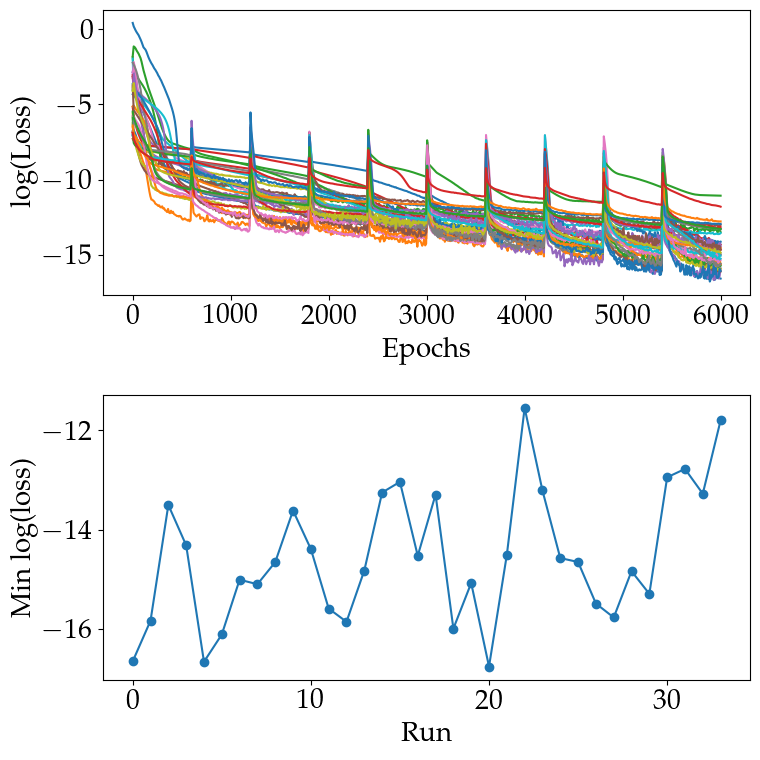

In [129]:
plot_loss_curves(losses,file_path_out=file_path_APAP_spiral_out, save_data=False)

Available runs: 34
Available runs: 34


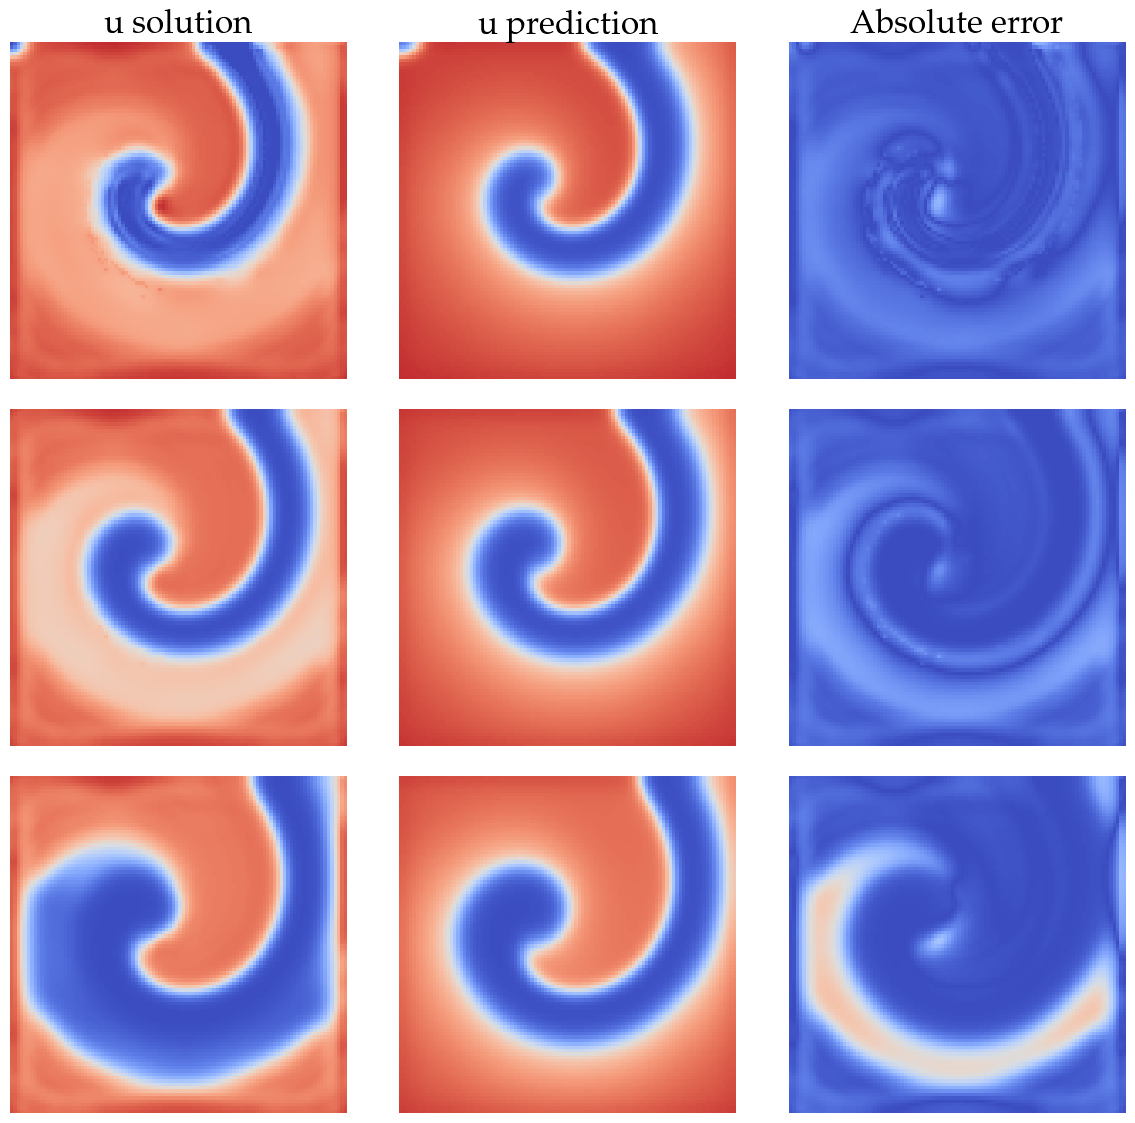

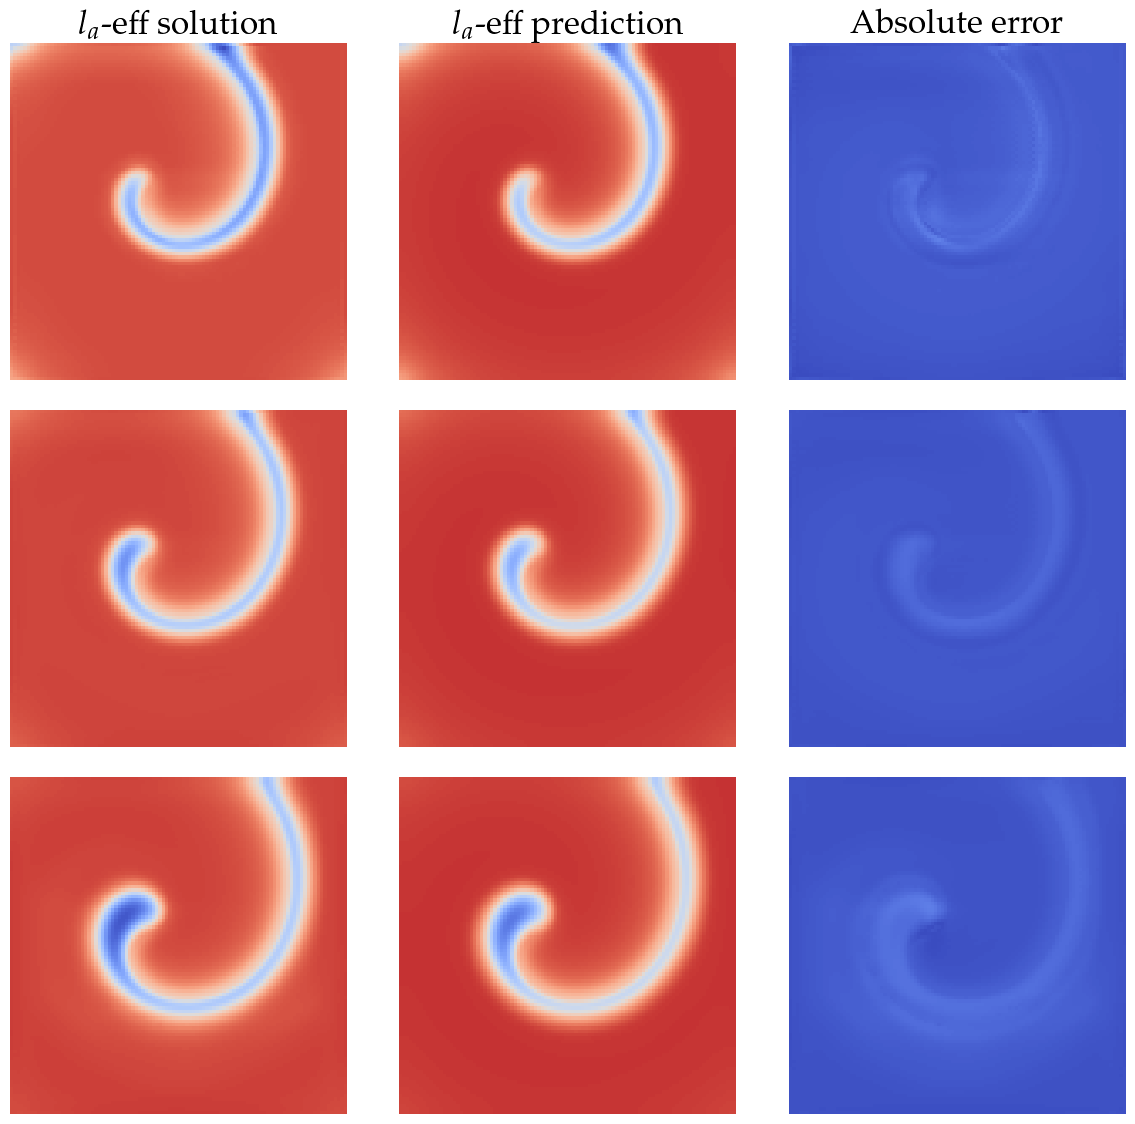

In [130]:
run = 6
plot_u_error(file_path_APAP_spiral_in, run,file_path_out=file_path_APAP_spiral_out,save_data=False)
plot_T_error(file_path_APAP_spiral_in, run,params,params_true_scroll,file_path_out=file_path_APAP_spiral_out,save_data=False)

Available runs: 34
Available runs: 34


/tmp/ipykernel_155809/423360320.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


Available runs: 34


/tmp/ipykernel_155809/423360320.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


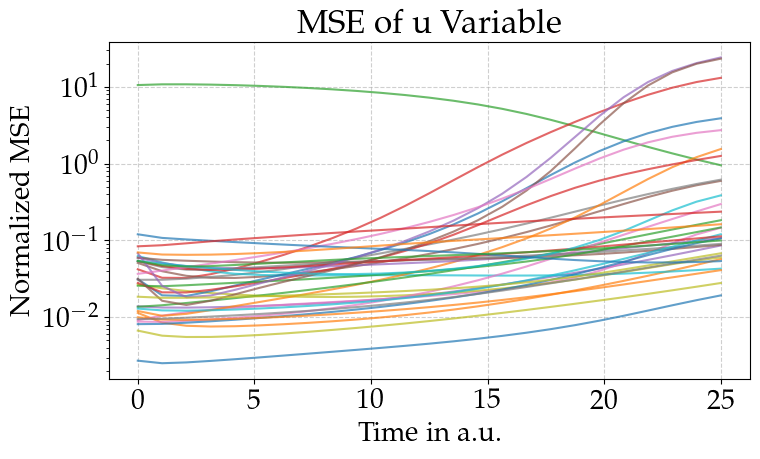

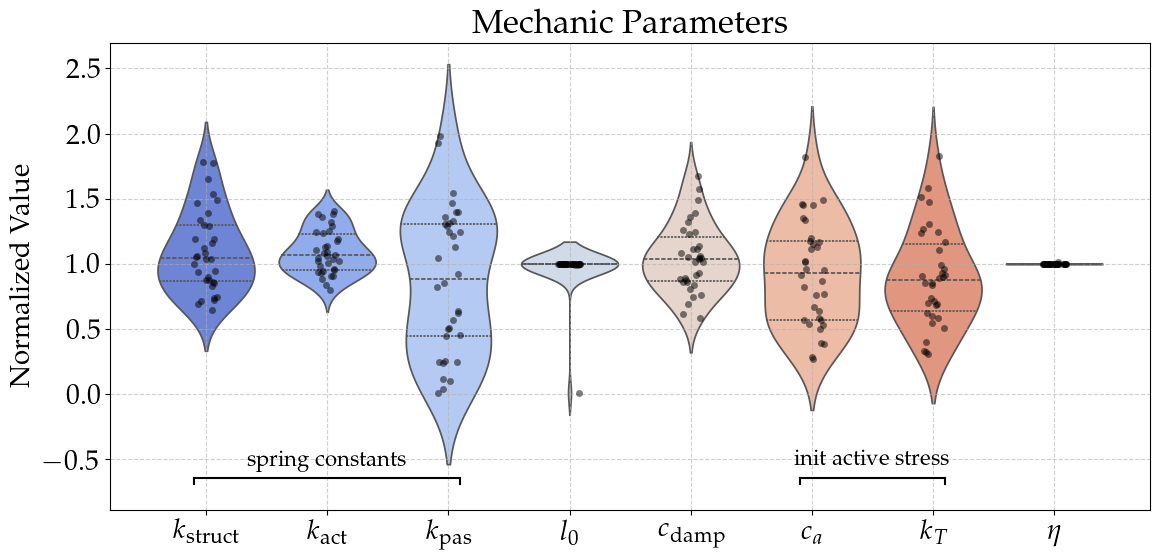

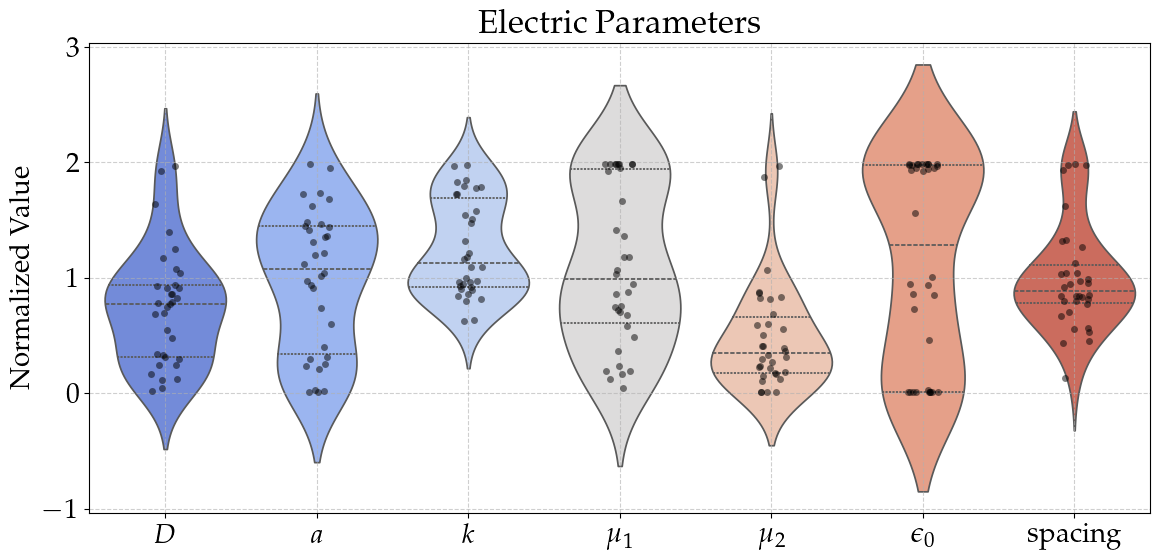

In [131]:
plot_u_mse_over_time(file_path_APAP_spiral_in,file_path_APAP_spiral_out,save_data=False)
violin_plot(file_path_APAP_spiral_in, mode="AP_AP", selected_keys=mech_keys,params_true=params_true_scroll, param_labels = param_labels,file_path_out=file_path_APAP_spiral_out,title = 'Mechanic Parameters',save_data=False)
violin_plot(file_path_APAP_spiral_in, mode="AP_AP", selected_keys=electric_keys,params_true=params_true_scroll, param_labels = param_labels,file_path_out=file_path_APAP_spiral_out,title  = 'Electric Parameters',save_data=False)

In [132]:
35*12*25/(15*15*13)

3.58974358974359